# **Heart rate estimation project Matt Supline**
### by Erica Brisigotti, Ekaterina Chueva, Maximilian Peter, Nadillia Saphutra

## 0. **Introduction**
[THIS PART MUST BE CHANGED AND INTEGRATED WITH DETAILS ABOUT HEART RATE AND CYCLE, SCG AND BCG, AND WITH ALL THE THEORETICAL INFO THAT WE'RE USING TO MAKE INFORMED DECISIONS LATER IN THE ANALYSIS PART]

Seismocardiography([SCG](https://www.ncbi.nlm.nih.gov/pubmed/24111357)) is a very promising technique to measure Heart Rate (HR) and Respiratory Rate (RR) with the detector positioned above sternum. It is generally based on accelerometer and gyroscope readings or a combination of them. 

Ballistocardiography([BCG](https://en.wikipedia.org/wiki/Ballistocardiography)) is an another technique to estimate heart and respiratory rate with combination of both accelerometer and gyroscope. It is an indirect evaluation of HR and RR since the contact between the device and the body of the subject is not required (e.g., accelerometer platform mounted under the slats of the bed).   
  
MuSe(Multi-Sensor miniaturized, low-power, wireless [IMU](https://en.wikipedia.org/wiki/Inertial_measurement_unit)) is an Inertial Measurement Unit (IMU) provide by [221e](https://www.221e.com). In the context of this project, It allows to record the inertial data necessary for the estimation of SCG and BCG.

The goal of this assignment is to estimate the heart rate of an healthy subject, given linear acceleration and angular velocity measurements recorded by using the aforementioned MuSe platform. 
The study must be performed on two datasets: the first is the compulsory one (**center_sternum.txt**) while the second is left at the discretion of the group, among those made available for the assignment.

**N.B: Remember that normal beat is around [40-100] bpm.**

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import fftpack, stats, signal
from scipy.optimize import curve_fit
import scipy.linalg as la
import pywt

## 1. **Data preparation**

### 1.1 **Selecting columns + accounting for offsets**

In [2]:
# Load the txt file and select only the columns you are interesting in, in order to do a complete data analysis (e.g. Log Freq, AccX, ... )

Even before uploading the data, it is well-known that there are 16 columns with different meanings. Specifically:
* **Log Freq** stands for the acquisition  in Hz (i.e., sampling interval is constant).
* **AccX, AccY, AccZ** are the measured magnitude of linear acceleration along each axis.
* **GyroX, GyroY, GyroZ** are the measured magnitude of angular velocity along each axis.
* **MagnX, MagnY, MagnZ** are the measured magnitude of magnetic field along each axis.
* **qw, qi, qj, qk** are the quaternion components, representing the spatial orientation of the Muse system.

Further *a priori* information follows from the theoretical information (previously explained in the introduction) about the techniques to be implemented: SCG and BCG. Both of these strategies analyse the evolution in time of accelleration and angular momentum. Therere, only accelerometer, gyrometer and time measurements will be needed.

The other physical quantities can be discarded.

Such statements are supported by the data, which is uploaded (as a Pandas' dataframe) and statistically analyzed through the appropriate Pandas' built-in function (<a href="https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.describe.html"> <code>pandas.describe</code> </a>).

In [3]:
file_name = '2_Mattress_supine.txt'
just_uploaded = pd.read_csv(file_name, delimiter='\t')
all_data = pd.DataFrame(just_uploaded)
display(all_data)
all_data.describe()

,Log Mode,Log Freq,Timestamp,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ,qw,qi,qj,qk
0,5,100,1555487805,413.824,-254.431,820.572,71.21951,-13.292680,19.14634,-251,144,-456,0.056576,-0.154179,0.248573,-0.954588
1,5,100,1555487805,383.263,-147.254,1010.404,24.87805,2.195122,11.70732,-618,152,-247,0.094745,-0.193243,0.047029,-0.975433
2,5,100,1555487805,362.950,-128.649,995.764,40.00000,-3.048780,21.09756,-618,152,-248,0.057454,-0.193945,0.045503,-0.978271
3,5,100,1555487805,391.925,-135.115,913.780,36.82927,3.780488,25.60976,-618,152,-247,0.046736,-0.193915,0.044099,-0.978912
4,5,100,1555487805,404.735,-150.731,890.478,33.29268,11.707320,30.36585,-617,151,-248,0.042185,-0.193335,0.043092,-0.979278
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11741,5,100,1555488314,121.146,115.473,859.246,-42.43903,57.560980,18.53659,-75,50,-405,0.975118,0.142308,-0.084109,0.147710
11742,5,100,1555488314,210.938,146.705,797.758,-44.26830,51.829270,24.51220,-73,53,-405,0.975712,0.137944,-0.080416,0.149968
11743,5,100,1555488314,190.259,130.479,793.305,-41.09756,44.878050,29.02439,-68,55,-406,0.976145,0.133732,-0.077334,0.152562
11744,5,100,1555488314,265.472,203.008,795.684,-31.46342,33.048780,27.31707,-64,57,-406,0.976378,0.130314,-0.075045,0.155156


,Log Mode,Log Freq,Timestamp,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ,qw,qi,qj,qk
count,11746.0,11746.0,1.174600e+04,11746.000000,11746.000000,11746.000000,11746.000000,11746.000000,11746.000000,11746.000000,11746.000000,11746.000000,11746.000000,11746.000000,11746.000000,11746.000000
mean,5.0,100.0,1.555488e+09,221.898380,-169.411822,970.157014,-3.901567,0.961697,-0.717193,-430.918866,397.258556,-334.883875,0.475773,-0.127853,0.023106,-0.843023
std,0.0,0.0,3.676787e+01,107.461932,119.407696,91.606409,21.018200,23.090912,17.302817,55.919537,85.499600,52.792339,0.072929,0.089694,0.048464,0.174249
min,5.0,100.0,1.555488e+09,-1016.077000,-1182.485000,-1078.000000,-611.097600,-544.756100,-231.463400,-725.000000,-329.000000,-456.000000,0.011254,-0.586535,-0.420362,-0.995758
25%,5.0,100.0,1.555488e+09,219.112000,-183.488000,975.390000,-2.804878,1.585366,0.121951,-438.000000,410.000000,-342.000000,0.474447,-0.139409,0.017396,-0.869045
50%,5.0,100.0,1.555488e+09,222.772000,-181.109000,981.917000,-2.682927,1.707317,0.243902,-437.000000,410.000000,-341.000000,0.474637,-0.139012,0.017670,-0.868954
75%,5.0,100.0,1.555488e+09,226.188000,-178.791000,988.184750,-2.560976,1.829268,0.365854,-436.000000,411.000000,-340.000000,0.474835,-0.138523,0.017945,-0.868892
max,5.0,100.0,1.555488e+09,1453.691000,1026.264000,1843.420000,336.341500,365.609800,178.658500,-52.000000,660.000000,178.000000,0.976411,0.623646,0.468978,0.882534


In [4]:
# timestamp have repetitive values that may represent a meaningful division of the data, but there's no info that supports it

The brief descriptive statistics provided by the <code>pandas.describe</code> function are particularly helpful in getting the time at which every measurement has been taken.
The **Log Freq** data, which represents the acquisition rate (in Hz), is constant and therefore allows for straigh-forward identification of the time interval between two successive measurements:

In [5]:
freq = all_data['Log Freq'].unique()[0] # Hz
time = np.arange(0,(len(all_data.index)/freq),(1/freq)) # seconds

Furthermore, the units of measurement for acceleration (mg, i.e. milli-g) and angular velocity (dps, i.e. degrees per second) are found in the calibration file (**README1.txt**).
$$ w[rad/s] = \frac{w[dps]*200}{2^{15}}*\frac{\pi}{180} $$


All unnecessary columns can now be dropped and a new one can be added to store the corresponding values of time.

In [6]:
data = all_data.drop(['MagnX','MagnY','MagnZ','qw','qi','qj','qk','Log Mode','Log Freq','Timestamp'], axis = 1)
data.insert(0, "Time", time)
data #.describe()

,Time,AccX,AccY,AccZ,GyroX,GyroY,GyroZ
0,0.00,413.824,-254.431,820.572,71.21951,-13.292680,19.14634
1,0.01,383.263,-147.254,1010.404,24.87805,2.195122,11.70732
2,0.02,362.950,-128.649,995.764,40.00000,-3.048780,21.09756
3,0.03,391.925,-135.115,913.780,36.82927,3.780488,25.60976
4,0.04,404.735,-150.731,890.478,33.29268,11.707320,30.36585
...,...,...,...,...,...,...,...
11741,117.41,121.146,115.473,859.246,-42.43903,57.560980,18.53659
11742,117.42,210.938,146.705,797.758,-44.26830,51.829270,24.51220
11743,117.43,190.259,130.479,793.305,-41.09756,44.878050,29.02439
11744,117.44,265.472,203.008,795.684,-31.46342,33.048780,27.31707


We can now finally use the information given by the calibration (contained in 'README5' for the "center_sternum" file), at least the more obvious ones given by the offset of the accelerometer.

In [7]:
acc_offsets = np.array( [3.602701 , -20.96658 , 54.97186 ] )
gyro_offsets = np.array([-2.804399, 1.793105, 0.3411708])

data['AccX'] += acc_offsets[0]
data['AccY'] += acc_offsets[1]
data['AccZ'] += acc_offsets[2]
data['GyroX'] += gyro_offsets[0]
data['GyroY'] += gyro_offsets[1]
data['GyroZ'] += gyro_offsets[2]


data.describe()

,Time,AccX,AccY,AccZ,GyroX,GyroY,GyroZ
count,11746.000000,11746.000000,11746.000000,11746.000000,11746.000000,11746.000000,11746.000000
mean,58.725000,225.501081,-190.378402,1025.128874,-6.705966,2.754802,-0.376022
std,33.909225,107.461932,119.407696,91.606409,21.018200,23.090912,17.302817
min,0.000000,-1012.474299,-1203.451580,-1023.028140,-613.901999,-542.962995,-231.122229
25%,29.362500,222.714701,-204.454580,1030.361860,-5.609277,3.378471,0.463122
50%,58.725000,226.374701,-202.075580,1036.888860,-5.487326,3.500422,0.585073
75%,88.087500,229.790701,-199.757580,1043.156610,-5.365375,3.622373,0.707024
max,117.450000,1457.293701,1005.297420,1898.391860,333.537101,367.402905,178.999671


### 1.2 **representing the columns + selecting an appropriate time-window**

In [8]:
# Plot selected data in function of time and choose a properly time window over which to perform the analysis. 
# Pay attention on time rappresentation and the measurament unit.

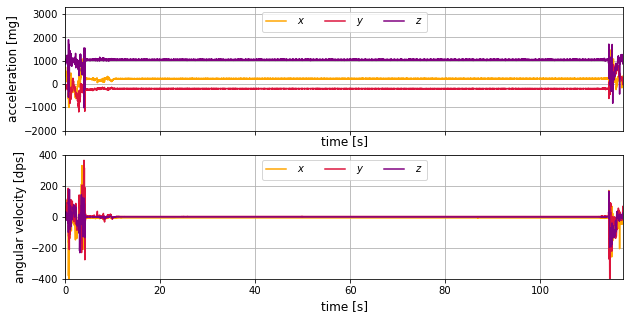

In [9]:
fig1 , ax1 = plt.subplots( nrows = 2 , ncols = 1 , sharex = True , figsize=(10,5 ))

ax1[0].plot( data['Time'] , data['AccX'] , '-' , label=' $x$ ' , color='orange' )
ax1[0].plot( data['Time'] , data['AccY'] , '-' , label=' $y$ ' , color='crimson' )
ax1[0].plot( data['Time'] , data['AccZ'] , '-' , label=' $z$ ' , color='purple' )
ax1[0].set_xlim( 0 , data['Time'].max() )
ax1[0].set_ylim( -2000 , 3300 )
ax1[0].set_xlabel( 'time [s]' , fontsize = 12 )
ax1[0].set_ylabel( 'acceleration [mg]' , fontsize = 12 )
ax1[0].legend( loc='upper center' , fontsize = 10 , ncol = 3 )
ax1[0].grid()

ax1[1].plot( data['Time'] , data['GyroX'] , '-' , label = ' $x$ ' , color='orange' )
ax1[1].plot( data['Time'] , data['GyroY'] , '-' , label = ' $y$ ' , color='crimson' )
ax1[1].plot( data['Time'] , data['GyroZ'] , '-' , label = ' $z$ ' , color='purple' )
ax1[1].set_xlim( 0 , data['Time'].max() )
ax1[1].set_ylim( -400 , 400 )
ax1[1].set_xlabel( 'time [s]' , fontsize = 12 )
ax1[1].set_ylabel( 'angular velocity [dps]' , fontsize = 12 )
ax1[1].legend( loc='upper center' , fontsize = 10  , ncol = 3 )
ax1[1].grid()


A few observations come up from a graphical representation of the remaining data:
- all measurements follow a similar trend, which consists of small obscillations around an offset for the majority of time and some larger fluctuations at the beginning and end
- supposing that the larger fluctuations were caused by the heartbeat, it follows that the patient's heart doesn't beat for over a minute (i.e. is dead) which is paradoxical: it follows that the interesting, heart-related information will be contained in the innermost, small obscillating portion of each set of measurement
- the larger fluctuations at the beginning and at the end of each measurement set are therefore regarded as anomalies (i.e. to be discarded), possibly due to the patient positioning himself or the devices being set up for the measurements

A quantitative approach to the selection of the data to be kept is explained below. The algorithm starts from the center of the dataset to take increasingly wider subsets and calculate the corresponding standard deviation.
The selection is later made based on the evolution of standard deviation 

In [10]:
def std_from_center( vect ):
    vect = np.array( vect )
    center_idx = int( vect.shape[0]/2 )
    std_down = [ np.std(vect[ (center_idx-idx):center_idx ] ) for idx in range(1,center_idx,1) ] 
    std_up = [ np.std( vect[ center_idx:(center_idx+idx) ] ) for idx in range(1,center_idx,1) ] 
    return np.concatenate((std_down[::-1],std_up))

5873
the percentage of measurements to keep is  76.62182870764515
13.73 103.73


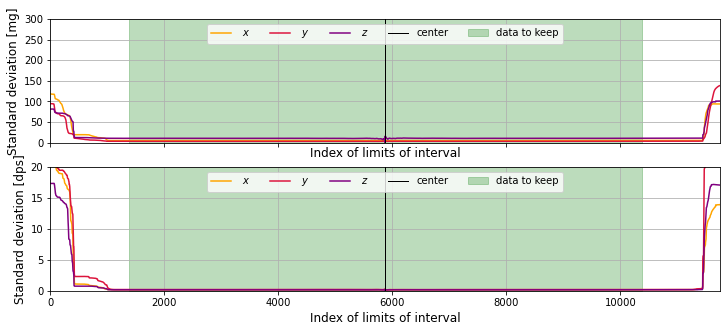

In [11]:
fig2,ax2 = plt.subplots( nrows = 2 , ncols = 1 , sharex = True , figsize = ( 12 , 5 ) )
center_idx = int( data.shape[0]/2 )
down_cut = 4500
up_cut = 4500
print( center_idx )
print('the percentage of measurements to keep is ', (down_cut+up_cut)/data.shape[0]*100)
down_idx = center_idx-down_cut
up_idx = center_idx+up_cut
down_limit = ( data['Time'] )[ down_idx ]
up_limit =( data['Time'] )[ up_idx ]
print(down_limit,up_limit)

ax2[0].plot( std_from_center( data['AccX']) , '-' , label = ' $x$ ' , color='orange' )
ax2[0].plot( std_from_center( data['AccY']) , '-' , label = ' $y$ ' , color='crimson' )
ax2[0].plot( std_from_center( data['AccZ']) , '-' , label = ' $z$ ' , color='purple' )
ax2[0].axvline( x = center_idx , linestyle = '-' , color = 'k' , label = 'center' , linewidth = 1 )
ax2[0].fill_betweenx( y = [0,300] , x1 = down_idx , x2 = up_idx , color='forestgreen' , alpha =0.3 , label = 'data to keep' )
ax2[0].set_xlim( 0 , data.shape[0] )
ax2[0].set_ylim( 0 , 300 )
ax2[0].set_xlabel( 'Index of limits of interval' , fontsize = 12 )
ax2[0].set_ylabel( 'Standard deviation [mg]' , fontsize = 12 )
ax2[0].legend( loc = 'upper center' , ncol = 5 , fontsize = 10 )
ax2[0].grid()

ax2[1].plot( std_from_center( data['GyroX']) , '-' , label = ' $x$ ' , color='orange' )
ax2[1].plot( std_from_center( data['GyroY']) , '-' , label = ' $y$ ' , color='crimson' )
ax2[1].plot( std_from_center( data['GyroZ']) , '-' , label = ' $z$ ' , color='purple' )
ax2[1].axvline( x = center_idx , linestyle = '-' , color = 'k' , label = 'center' , linewidth = 1 )
ax2[1].fill_betweenx( y = [0,20] , x1 = down_idx, x2 = up_idx , color='forestgreen' , alpha = 0.3 , label='data to keep' )
ax2[1].set_xlim( 0 , data.shape[0] )
ax2[1].set_ylim( 0 , 20 )
ax2[1].set_xlabel( 'Index of limits of interval' , fontsize = 12 )
ax2[1].set_ylabel( 'Standard deviation [dps]' , fontsize = 12 )
ax2[1].legend( loc = 'upper center' , ncol = 5 , fontsize = 10 )
ax2[1].grid()

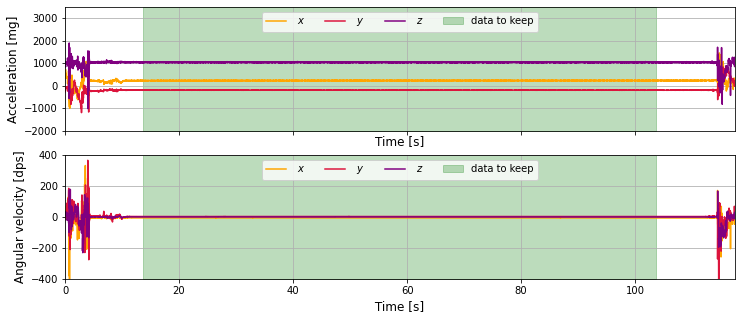

In [12]:
fig3, ax3 = plt.subplots( nrows = 2 , ncols = 1 , sharex = True , figsize = (12,5) )

ax3[0].plot( data['Time'] , data['AccX'] , '-' , label = ' $x$ ' , color = 'orange' )
ax3[0].plot( data['Time'] , data['AccY'] , '-' , label = ' $y$ ' , color = 'crimson' )
ax3[0].plot( data['Time'] , data['AccZ'] , '-' , label = ' $z$ ' , color = 'purple' )
ax3[0].fill_betweenx( y = [-2000,+3500] , x1 = down_limit , x2 = up_limit , color='forestgreen' , alpha =0.3 , label = 'data to keep' )
ax3[0].set_xlim( min(data['Time']) , max(data['Time']) )
ax3[0].set_ylim( -2000 , +3500 )
ax3[0].set_xlabel( 'Time [s]' , fontsize = 12 )
ax3[0].set_ylabel( 'Acceleration [mg]' , fontsize = 12 )
ax3[0].legend( loc = 'upper center' , ncol = 4 , fontsize = 10 )
ax3[0].grid()

ax3[1].plot( data['Time'] , data['GyroX'] , '-' , label = ' $x$ ' , color='orange' )
ax3[1].plot( data['Time'] , data['GyroY'] , '-' , label = ' $y$ ' , color='crimson' )
ax3[1].plot( data['Time'] , data['GyroZ'] , '-' , label = ' $z$ ' , color='purple' )
ax3[1].fill_betweenx( y=[ -400 , +400 ] , x1=down_limit , x2 = up_limit , color='forestgreen' , alpha =0.3 , label = 'data to keep' )
ax3[1].set_xlim( min( data['Time'] ) , max( data['Time'] ) )
ax3[1].set_ylim( -400, +400 )
ax3[1].set_xlabel( ' Time [s] ' , fontsize=12 )
ax3[1].set_ylabel( ' Angular velocity [dps] ' , fontsize=12 )
ax3[1].legend( loc = 'upper center' , ncol = 4 , fontsize = 10 )
ax3[1].grid()

In [13]:
ok_data = data.copy()
ok_data.drop( data[ data['Time'] <= down_limit ].index, inplace=True)
ok_data.drop( data[ data['Time'] >= up_limit ].index, inplace=True)
ok_data.set_index( np.arange(len(ok_data) ),inplace=True)

### 1.3 **PCA + choosing an appropriate combination of columns**

In [14]:
# In order to make an appropiate work, decide if take care about some particular axis or some combination of them as well as derived features for the next step of the task. Motivate your choice.

In [15]:
def PCA_pairplot( vect ):
    # sns.pairplot( vect , height = 2)
    vect_cov = np.cov( vect.T )
    vect_val , vect_vect = la.eig( vect_cov )
    vect_val = np.real_if_close( vect_val )
    perc = vect_val*100/vect_val.sum()
    return perc

#### 1.3.1 **PCA on acceleration**

In [16]:
print( 'the percentages corresponding the components of the acceleration are ' , PCA_pairplot( ok_data[ ['AccX','AccY','AccZ'] ] ) )

the percentages corresponding the components of the acceleration are  [76.59709874 16.92176833  6.48113293]


#### 1.3.2 **PCA on angular velocity**

In [17]:
print( 'the percentages corresponding the components of the angular velocity are ' , PCA_pairplot( ok_data[ ['GyroX','GyroY','GyroZ'] ] ) )

the percentages corresponding the components of the angular velocity are  [24.68299384 29.61879223 45.69821393]


#### 1.3.3 **Combining columns**

None of the components can be discarded since all the corresponding percentages are non-negligible. On the other hand, they can be combined into a single variable to smoothen future analysis. 

The simplest approach consists of switching from a Carthesian to a polar set of coordinates

$$ \vec{v} \rightarrow \left(\,  x \, , \, y \, , \, z \, \right) \rightarrow \left(\,  \| \vec{v} \| \, , \, \theta \, , \, \phi \, \right) \;\;\; \text{where} \;\;\; \| \vec{v} \| = \sqrt{x^2 + y^2 + z^2} $$

and consider the norm $\| \vec{v} \|$ of the physical quantity $\vec{v}$. 

There is no need to switch to the eigenvector basis (from PCA) before calculating the norm $\| \vec{v} \|$ since it is invariant under rotations of the plane around the origin.

In [18]:
acc_norm = np.array( np.sqrt( ok_data['AccX']**2 + ok_data['AccY']**2 + ok_data['AccZ']**2 ))
gyro_norm = np.array( np.sqrt( ok_data['GyroX']**2 + ok_data['GyroY']**2 + ok_data['GyroZ']**2 ))

At the same time, the normalized norms of these phisical quantities can be summed together, as seen in many examples in literature. This combination is justified by the fact that the waves are in phase.

In [19]:
time = np.array( ok_data['Time'] )
# norm = np.sqrt( ( acc_norm/np.linalg.norm(acc_norm) )**2 + ( gyro_norm/np.linalg.norm(gyro_norm) )**2 )
norm = acc_norm/np.linalg.norm(acc_norm) + gyro_norm/np.linalg.norm(gyro_norm)
# time = np.concatenate( (np.array( ok_data['Time'] ), np.array( ok_data['Time'] )))
# norm = np.concatenate( ( acc_norm/np.linalg.norm(acc_norm) , gyro_norm/np.linalg.norm(gyro_norm) ) )
to_analyze = pd.DataFrame( { 'Time' : time , 'Norm' : norm })

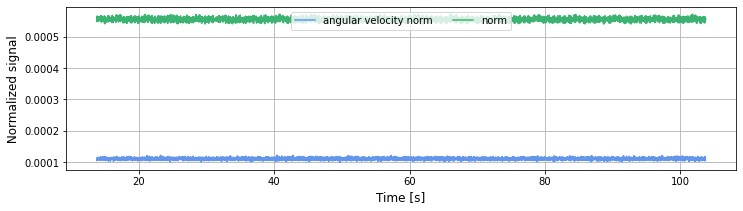

In [20]:
fig4, ax4 = plt.subplots( nrows = 1 , ncols = 1 , sharex = True , figsize = (12,3) )

ax4.plot( ok_data['Time'] , gyro_norm /gyro_norm.sum(), '-' , label = 'angular velocity norm' , color = 'cornflowerblue' )
ax4.plot( ok_data['Time'] , acc_norm/acc_norm.sum()*5 , '-' , label = 'norm' , color = 'mediumseagreen' )
#ax4.plot( time , norm , '-' , label = 'sum of norms' , color = 'navy' )
#ax4.set_xlim( min( time ) , max( time ) )
# ax4.set_xlim( 10 , 11 )
#ax4.set_ylim( 0.000018 , 0.00012 )
#ax4.set_ylim( 0.000018 , 0.0003 )
ax4.set_xlabel( 'Time [s]' , fontsize = 12 )
ax4.set_ylabel( ' Normalized signal ' , fontsize = 12 )
ax4.legend( loc = 'upper center' , ncol = 3 , fontsize = 10 )
ax4.grid()


### 1.4. **Statistical analysis**

Before moving further into the analyis, we provide a statistical description of the combined dataset.

In [21]:
#Investigate what could be the most interesting descriptors for this type of data, motivating the choices.

In [22]:
std_description = pd.concat( [ to_analyze.describe() , pd.DataFrame( to_analyze.median() , columns=['median'] ).transpose() , 
                                pd.DataFrame( to_analyze.var(), columns=['variance'] ) .transpose() ] )
std_description

,Time,Norm
count,8999.000000,8.999000e+03
mean,58.730000,2.107886e-02
std,25.979319,2.945316e-04
min,13.740000,1.993594e-02
25%,36.235000,2.088235e-02
50%,58.730000,2.107470e-02
75%,81.225000,2.127949e-02
max,103.720000,2.236432e-02
median,58.730000,2.107470e-02
variance,674.925000,8.674885e-08


In [23]:
to_analyze.corr()

,Time,Norm
Time,1.000000,0.001081
Norm,0.001081,1.000000


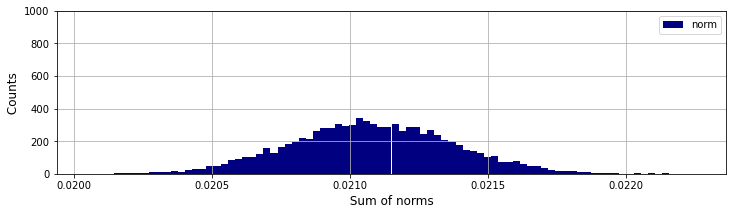

In [24]:
fig5, ax5 = plt.subplots( nrows = 1 , ncols = 1 , figsize=(12,3) )
ax5.hist( norm , bins = int( np.sqrt( len(norm) ) ) , label = 'norm' , color = 'navy' )
ax5.set_xlim( min( norm ) , max( norm ) )
ax5.set_ylim( 0 , +1000 )
ax5.set_xlabel( ' Sum of norms ' , fontsize = 12 )
ax5.set_ylabel( ' Counts ' , fontsize = 12 )
ax5.legend( loc = 'upper right' , ncol = 2 , fontsize = 10 )
ax5.grid()
plt.show()

## 2. **Fourier Analysis: FFT and band-pass filter**

The first strategies implemented consists of a Fast Fourier Transform algorythm. The algorythm computes the discrete Fourier transform of the signal (in section 2.1), particularly its power. A desired frequency can be identified as the one of the local maxima of the power.

A band-pass filter is then applied to the power (in section 2.2) to select the desired local minima based on the range of theoretically possible heart-rates (40-100 bpm). It can be used, independently of heart-rate identification, as method to get a clearer signal.

### 2.1 **FFT +  power plot**

In [25]:
# Perform a frequency analysis of the data. Look at the spectrum and explain what you see.

In [26]:
def power_fft( vect , timestamp ):
    # The FFT of the signal Z around the area of heart beat frequencies
    vect_fft = fftpack.fft( vect )
    # And the power (sig_fft is of complex dtype)
    vect_power = np.abs( vect_fft )
    # The corresponding frequencies
    vect_all_freq = fftpack.fftfreq( vect.size, d = timestep )
    return vect_fft , vect_power , vect_all_freq

timestep = 1/freq
norm_fft , norm_power , norm_all_freq = power_fft( np.asarray(to_analyze['Norm']) , timestep )

In [27]:
down_freq_lim = 40/60 # Hz
up_freq_lim = 100/60 # Hz

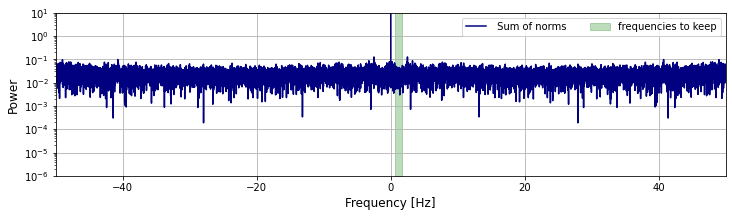

In [28]:
fig6 , ax6 = plt.subplots( nrows = 1 , ncols = 1 , figsize = (12,3) )
ax6.plot( norm_all_freq , norm_power , '-' , label = ' Sum of norms ' , color = 'navy' )
ax6.fill_betweenx( y=[ 10**(-6) , 10**1 ] , x1 = down_freq_lim , x2 = up_freq_lim , color = 'forestgreen' , alpha = 0.3 , label = 'frequencies to keep' )
ax6.set_xlim( min( norm_all_freq ) , max( norm_all_freq ) )
ax6.set_ylim( 10**(-6) , 10**1 )
ax6.set_xlabel( 'Frequency [Hz]' , fontsize = 12 )
ax6.set_ylabel( 'Power' , fontsize = 12 )
ax6.set_yscale( 'log' )
ax6.legend( loc = 'upper right' , ncol = 2 , fontsize = 10 )
ax6.grid()
plt.show()

### 2.2 **Band-pass filter + heart-rate estimation via FFT**

In [29]:
# Use this step in order to properly design the filters in the following step.

In [30]:
# Adjust mask to freq of heart beat (40bpm and  100 bpm) translate it to sec

def band_pass_filter( vect_all_freq , vect_power, down_freq_lim , up_freq_lim ):
    vect_mask = np.where( ( 40/60 <= vect_all_freq ) & ( vect_all_freq <= 100/60 ) )
    vect_freq = vect_all_freq [ vect_mask ]
    vect_peak_freq = vect_freq [ vect_power [ vect_mask ].argmax() ]
    vect_err_peak_freq = ( vect_freq [ (vect_power [ vect_mask ]).argmax() + 1 ] - vect_freq [ (vect_power [ vect_mask ]).argmax() - 1 ] ) / 2
    return vect_mask , vect_freq , vect_peak_freq , vect_err_peak_freq

norm_mask , norm_freq , fft_peak_freq , fft_err_peak_freq = band_pass_filter( norm_all_freq , norm_power , down_freq_lim , up_freq_lim )

print('the peak frequency estimated from the sum of norms is ', fft_peak_freq*60 ,' ± ',fft_err_peak_freq*60 ,' bpm')

the peak frequency estimated from the sum of norms is  41.3379264362707  ±  0.6667407489721078  bpm


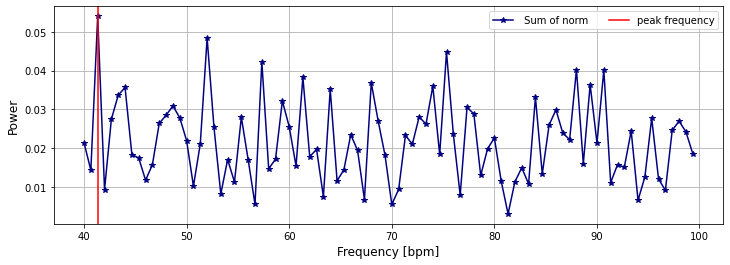

In [31]:
fig7, ax7 = plt.subplots( nrows = 1 , ncols = 1 , figsize = (12,4) )
ax7.plot( norm_freq*60 , norm_power[norm_mask] , '-*' , label = ' Sum of norm' , color = 'navy' )
ax7.axvline( fft_peak_freq*60 , color='red' , label = 'peak frequency')
# ax7.set_xlim( down_freq_lim*60 , up_freq_lim*60 )
#ax7.set_ylim( 0 , 0.03 )
ax7.set_xlabel( 'Frequency [bpm]' , fontsize = 12 )
ax7.set_ylabel( 'Power' , fontsize = 12 )
ax7.legend( loc = 'upper right' , ncol = 2 , fontsize = 10 )
ax7.grid()
plt.show()

### 2.3 **Filtering signal with FFT**

In [32]:
def filtered_power( vect_fft , vect_all_freq , down_freq_lim , up_freq_lim ):
    vect_filtered_fft = vect_fft.copy()
    vect_filtered_fft[ np.abs(vect_all_freq) >= 60/60 ] = 0
    vect_filtered_fft[ np.abs(vect_all_freq) <= 40/60 ] = 0
    vect_filtered = ( fftpack.ifft( vect_filtered_fft ) ).real
    return vect_filtered

norm_filtered = filtered_power( norm_fft , norm_all_freq , down_freq_lim , up_freq_lim )

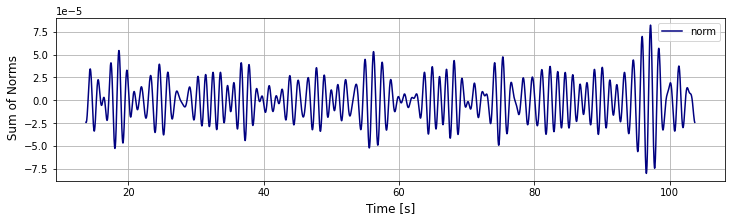

In [33]:
fig8 , ax8 = plt.subplots( nrows = 1 , ncols = 1 , figsize = ( 12 , 3 ) )
ax8.plot(to_analyze['Time'] , norm_filtered , '-' , label = 'norm' , color = 'navy' )
#ax8.set_xlim( 0 , len( norm_filtered_power ) )
#ax8.set_ylim( -5*10**(-5) , +5*10**(-5) )
ax8.set_xlabel( 'Time [s]' , fontsize = 12 )
ax8.set_ylabel( ' Sum of Norms' , fontsize = 12 )
ax8.legend( loc = 'upper right' , ncol = 2 , fontsize = 10 )
ax8.grid()
plt.show()

## 3. **Wavelet transform**

### 3.1 **Discrete Wavelet Transform**

In [34]:
# DWT function

def dwt(time, vect, level):
    i = level+1
    coef = pywt.wavedec(vect , 'rbio3.9', level=i )

    for k in range (i):
#         if (k != 1)&(k != 2): 
        if (k != 1): 
            coef[k] = np.zeros(coef[k].shape)
    dwt_sig = pywt.waverec( coef, 'rbio3.9' )
    fig9 , ax9 = plt.subplots( nrows = 1 , ncols = 1 , figsize = ( 12 , 3 ) )
    ax9.plot(time, dwt_sig[:-1]) #blocked the time frame to see the wave better
    #ax9.set_xlim(37,40)
    ax9.set_xlabel ("Time")
    ax9.set_ylabel ("Magnitude Freq ") #not sure this is the right name for the y axis
    plt.show
    return dwt_sig



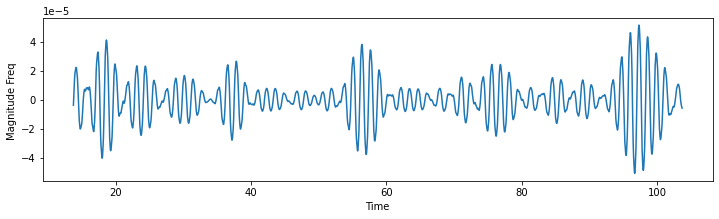

In [35]:
# function dwt(signal, level)
dwt_sig = dwt( time, norm_filtered , 6)

In [36]:
def peaks(time, vect):
    peaks, _ = signal.find_peaks(vect, width = 37) 
#     count BPM
    num_peak = len(peaks)
    time  = time.max() - time.min()
    bps = num_peak/time 
    print('BPM is', bps*60)#times 60 for bpm
#     plot peaks
    plt.figure(figsize=(15, 5))
    plt.plot(vect)
    plt.plot(peaks, vect[peaks], "x")
    #plt.plot(np.zeros_like(x), "--", color="gray")
    plt.show()
    return (peaks)

BPM is 42.00933540786841


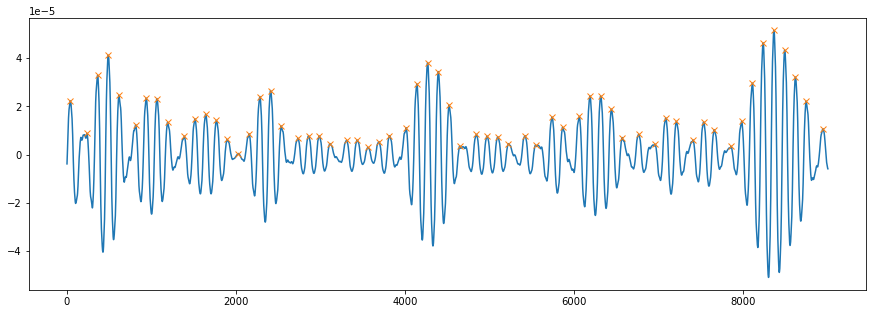

In [37]:
peak = peaks( to_analyze['Time'], dwt_sig)

In [38]:
# histogram functions
def histograms(time, peak):
    fig,ax = plt.subplots(ncols = 2, figsize = (12,5))
#     HRV Histogram
    times = np.asarray(time)
    hrv = np.zeros(len(peak)-1)
    for i in range (len(hrv)):
        hrv[i] = times[peak[i+1]] - times[peak[i]] 
    value_hrv, bins_hrv, _  = ax[0].hist(hrv,bins='sqrt', density = True,  stacked = True,  color ='lightblue', ec = 'navy')
    ax[0].set_xlabel ("HRV (second)")
    
# histogram of BPM
    value_heart, bins_heart, _ = ax[1].hist(1/hrv*60,bins='sqrt', density = True, stacked = True, color ='lightblue', ec = 'navy')
    ax[1].set_xlabel ("HBM")
    return hrv, value_hrv, bins_hrv, value_heart, bins_heart

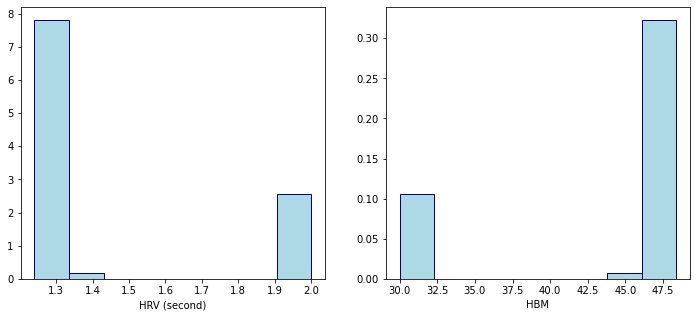

In [39]:
hrv, value_hrv, bins_hrv, value_heart, bins_heart = histograms(to_analyze['Time'], peak)

In [40]:
# #I want to try to fit with Gaussian, Cauchy, Double exponenetial

# def Gauss(x,A,mu,sigma):
#     return A*np.exp(-(x - mu)**2/(2 * sigma**2)) 

# def Cauchy(x,A,t,s):
#     return A/(s*np.pi*(1 + ((x-t)/s)**2 )) 

# # def Double_exp(x,A,mu,b,B):
# #     return A*np.exp(-np.abs( (x-mu)/b ))/(2*b) + B

# ##hrv part
# bins_mean_hrv=(bins_hrv[:-1]+bins_hrv[1:])/2  
# #print(bins_mean_hrv)
# #print(value_hrv)

# opt_gauss, cov_gauss = curve_fit(Gauss, xdata=bins_mean_hrv, ydata=value_hrv, p0=[16, 0.85, 0.1])
# print('Gaussian')
# print(opt_gauss)
# print(cov_gauss)


# opt_cauchy, cov_cauchy = curve_fit(Cauchy, xdata=bins_mean_hrv, ydata=value_hrv, p0=[16, 0.85, 0.1])
# print('Cauchy')
# print(opt_cauchy)
# print(cov_cauchy)

# # opt_dexp, cov_dexp = curve_fit(Double_exp, xdata=bins_mean_hrv, ydata=value_hrv, p0=[16, 0.85, 0.1, 2])
# # print('Double exponential')
# # print(opt_dexp)
# # print(cov_dexp)


# xspace = np.linspace(0.6,1.1,100)
# plt.figure(figsize=(10,8))
# plt.hist(hrv, bins='auto', alpha=0.6, density = True, stacked = True)
# plt.plot(xspace, Gauss(xspace, *opt_gauss), color='red', linewidth=2.5, label='Gaussian', alpha=0.65)
# plt.plot(xspace, Cauchy(xspace, *opt_cauchy), color='purple', linewidth=2.5, label='Cauchy', alpha=0.65)
# # plt.plot(xspace, Double_exp(xspace, *opt_dexp), color='green', linewidth=2.5, label='Double exponential', alpha=0.65)
# plt.legend(loc='best', fontsize=14)
# plt.title('HRV', fontsize=16)
# plt.xlim(0.6,1.1)

In [41]:
# import scipy as sp
# import scipy.stats as stats



# def Gamma(x,A,mu,b):
#     g = 4
#     return ((x-mu)/b)**(g-1)*np.exp(-(x-mu)/b)*A/(b*sp.special.gamma(g))


# def Log_Logistics(x,A,a,b,B):
#     return A*(b/a)*(x/a)**(b-1)/(1 + (x/a)**b)**2 + B

# def Gauss2(x,A,mu,sigma,B):
#     return A*np.exp(-(x - mu)**2/(2 * sigma**2))+B 

# bins_mean_heart=(bins_heart[:-1]+bins_heart[1:])/2
# print(bins_mean_heart)

# opt_gauss, cov_gauss = curve_fit(Gauss2, xdata=bins_mean_heart, ydata=value_heart, p0=[0.1, 70, 10, 0.2])
# print('Gaussian')
# print(opt_gauss)
# print(np.sqrt(np.diag(cov_gauss)))

# #opt_invgauss, cov_invgauss = curve_fit(Inverse_Gauss, xdata=bins_mean_heart, ydata=value_heart, p0=[0.1, 70])
# #print('Inverse Gauss')
# #print(opt_invgauss)
# #print(cov_invgauss)

# #opt_gamma, cov_gamma = curve_fit(Gamma, xdata=bins_mean_heart, ydata=value_heart, p0=[2, 40, 5])
# #print('Gamma')
# #print(opt_gamma)
# #print(cov_gamma)


# opt_log, cov_log = curve_fit(Log_Logistics, xdata=bins_mean_heart, ydata=value_heart, p0=[1, 70, 20,0.1])
# print('Log')
# print(opt_log)
# print(np.sqrt(np.diag(cov_log)))


# xspace = np.linspace(56,90,100)
# plt.figure(figsize=(5,5))
# plt.hist((1/hrv)*60, bins='auto', alpha=0.6, density=True)
# plt.plot(xspace, Gauss2(xspace, *opt_gauss), color='red', linewidth=2.5, label='Gaussian', alpha=0.65)
# plt.plot(xspace, Log_Logistics(xspace, *opt_log), color='purple', linewidth=2.5, label='Log', alpha=0.65)
# #plt.plot(xspace, Gamma(xspace, *opt_gamma), color='green', linewidth=2.5, label='Gamma', alpha=0.65)
# plt.legend(loc='best', fontsize=14)
# plt.title('Heart rate', fontsize=16)
# plt.xlim(56,90)

### 3.2 **Continuous Wavelet Transform**

An alternative strategy for peak identification is given by the Continuous Wavlet transform, which has been implemented through the
<a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks_cwt.html"> <code>cwt_find_peaks</code> </a> Scipy function.

This time, the main 



In [42]:
from scipy import signal

def cwt(time, waves):
    peakind = signal.find_peaks_cwt(waves, np.arange(35,45), window_size = 20)
    temp = np.array(time[peakind])
    fig,ax = plt.subplots( figsize=(15,7) )
    ax.plot(time,waves,'-')
    ax.plot(temp, waves[peakind],'*')
    print(len(peakind),' peaks were found')
    print(len(peakind)/time[-1]*60, 'BPM')
    return temp
    

72  peaks were found
41.650597763208644 BPM


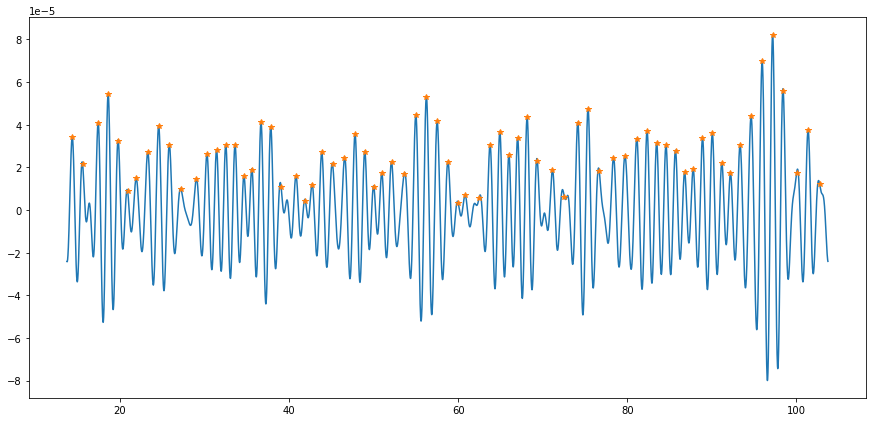

In [43]:
temp = cwt(time,norm_filtered)

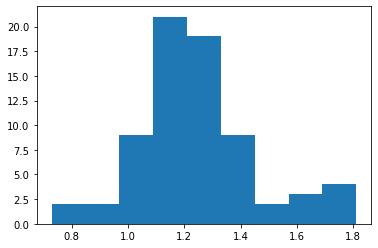

In [44]:
tt = []
# bb = []
tt.append([temp[i+1]-temp[i] for i in range (len(temp)-1)])
# bb.append([1/(temp[i+1]-temp[i])*60 for i in range (len(temp)-1)])
# print(tt)
plt.hist(tt, bins = 'sqrt')
plt.show()

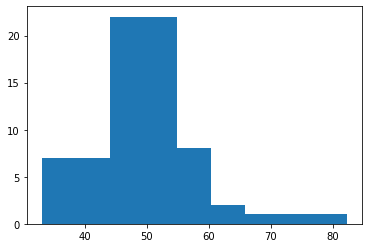

In [45]:
bb = 1/np.asarray(tt)*60
bb = bb.tolist()
plt.hist(bb, bins = 'sqrt')
plt.show()

## 4. **Conclusions**